In [1]:
from DNN_models import BayesFF_wrap
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

Include dropout in LSTM / CNN cells?

In [ ]:
def sinus(N, X_range, X_drop_range=[0,0], Q=1, sigma=2, heterosc=False):
    """
    Function to generate data
    """
    X_length = (X_range[1]- X_range[0])-(X_drop_range[1]- X_drop_range[0])
    X = np.random.uniform(0,X_length,(N,Q))
    X += X_range[0]
    for i in range(N):
        if X[i] > X_drop_range[0]:
            X[i] +=  X_drop_range[1]- X_drop_range[0]
    noise = sigma * np.random.randn(N, Q)
    if heterosc:
        noise *= (X - X_range[0])> (X_length / 2)
    Y = np.sin(1.8*X+.5) + noise
    return X, Y

In [3]:
N_train = 10000
X_RANGE_TRAIN = [-4,4]
X_DROP_RANGE =[0,0]

N_val = 100
X_RANGE_VAL =[-6,6]

NB_EPOCHS = 1000
NB_FEATURES = 100 #100
BATCH_SIZE = 1024
L = 1e-5#4
LOSS = "Euclidean"
HETEROSC = True
K_TEST  = 50 # Number of MC samples
P = 0.25
SIGMA = 1

In [7]:

def function(X):
    return np.power(np.sum(np.sqrt(X)), 2)

def plots(X_train, Y_train, X_val, Y_val, means, logvar, X_range, filename=None):
    indx = np.argsort(X_val[:, 0])

    Y_value_range = np.max(Y_train[:, 0])-np.min(Y_train[:, 0])
    Y_range = [np.min(Y_train[:, 0]) - Y_value_range / 5, np.max(Y_train[:, 0]) + Y_value_range / 5]
    fig, axes = plt.subplots(1,2,figsize=(16, 2), sharex=True, sharey=False)
    fig.suptitle('Results for the Bayesian neural network', fontsize=14, y=1.15)
    axes[0].set_xlim(X_range)
    axes[0].scatter(X_train[:, 0], Y_train[:, 0], c='y')
    axes[0].set_ylim(Y_range)
    axes[0].set_title('Train set')
    axes[1].scatter(X_val[:, 0], Y_val[:, 0], c='r', alpha=0.2, lw=0)
    axes[1].set_ylim(Y_range)
    axes[1].set_title('Test set X')

    if filename:
        plt.savefig(filename+"_0.png", bbox_inches='tight')
    plt.show()
    
    fig, axes = plt.subplots(1,2,figsize=(16, 2), sharex=True, sharey=False)
    fig.suptitle('Results for the Bayesian neural network', fontsize=14, y=1.15)
    axes[0].plot(X_val[indx, 0], np.mean(means, 0)[indx], color='skyblue', lw=3)
    axes[0].scatter(X_val[:, 0], Y_val[:, 0], c='r', alpha=0.2, lw=0)
    axes[0].set_ylim(Y_range)
    axes[0].set_title('Test set X and prediction')
    
    for mean in means:
        axes[1].scatter(X_val[:, 0], mean, c='b', alpha=0.2, lw=0)
    axes[1].plot(X_val[indx, 0], np.mean(means, 0)[indx], color='skyblue', lw=3)
    axes[1].set_ylim(Y_range)
    axes[1].set_title('Monte Carlo samples on test set')

    if filename:
        plt.savefig(filename+"_1.png", bbox_inches='tight')
    plt.show()
    


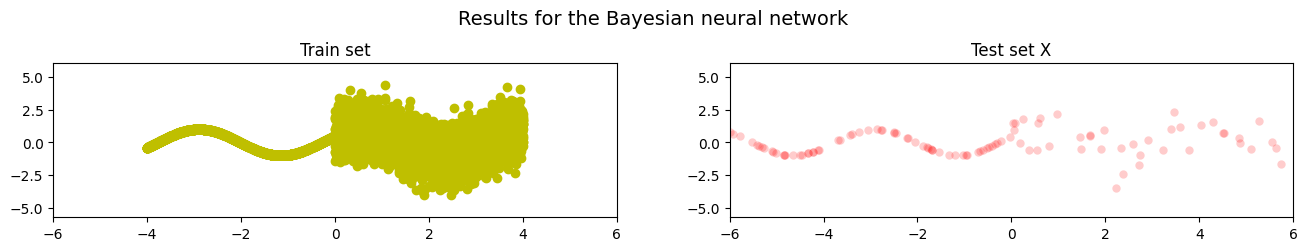

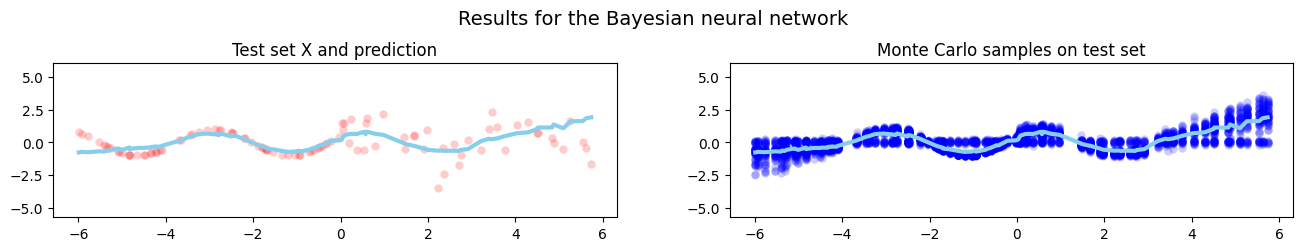

In [8]:
X_train, Y_train = sinus(N_train, X_RANGE_TRAIN, X_drop_range=X_DROP_RANGE, sigma=SIGMA, heterosc=True)
X_val, Y_val = sinus(N_val,X_RANGE_VAL, sigma=SIGMA, heterosc=True)
model = BayesFF_wrap(NB_EPOCHS, NB_FEATURES, BATCH_SIZE, L, loss=LOSS,heteroscedastic=HETEROSC, p=P)
model.fit(X_train, Y_train)

means, logvar, rmse, bnn_ps, bnn_aleatoric_uncertainty, epistemic_uncertainty = model.get_results(X_val, Y_val, K_TEST)

plots(X_train, Y_train, X_val, Y_val, means, logvar, X_RANGE_VAL, "BNN")

In [9]:
al_unc = np.exp(logvar)
y_pred = np.mean(means, 0)
ep_unc = np.var(means, 0) ** .5
tot_unc = al_unc + ep_unc
ep_unc_sq = np.sqrt(ep_unc)
al_unc_sq = np.sqrt(al_unc)
tot_unc_sq = np.sqrt(tot_unc)

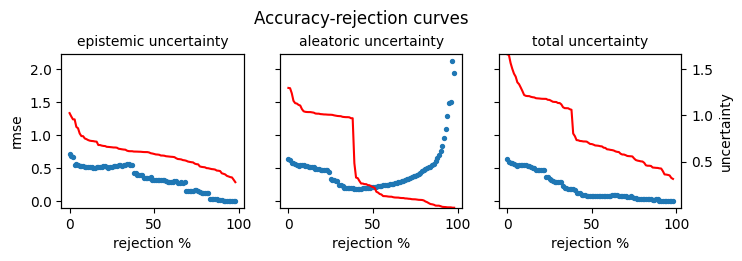

In [12]:
metric = mean_squared_error

def accuracy_rejection_unc(y_test_orig, y_test_hat_orig, uncs, uncertainties, filename):
    fig, ax = plt.subplots(1, 3, figsize=(8, 2), sharey=True, sharex=True)
    fig.suptitle(f'Accuracy-rejection curves', fontsize=12, y=1.1)
    min_unc = min(min(uncs[0]), min(uncs[1]))
    max_unc = max(uncs[2])
    for unc_nr, (unc, unc_type) in enumerate(zip(uncs, uncertainties)):
        sorted_idx = np.argsort(unc)
        unc = unc[sorted_idx]
        y_test = y_test_orig[sorted_idx]
        y_test_hat = y_test_hat_orig[sorted_idx]
        scores = []
        shares = []
        for i in range(len(y_test)-1):
            score = metric(y_test[:-i-1], y_test_hat[:-i-1])
            scores.append(score)
            shares.append(100 * i / len(y_test))

        ax[unc_nr].set_title(f"{unc_type} uncertainty", fontsize=10)
        if unc_nr == 0:
            ax[unc_nr].set_ylabel("rmse")
        ax[unc_nr].set_xlabel("rejection %")
        ax[unc_nr].scatter(shares, scores, label="", s=8)

        ax2 = ax[unc_nr].twinx()
        if unc_nr != 2:
            ax2.set_yticks([]) 
        else:
            ax2.set_ylabel("uncertainty") 
        ax2.set_ylim(min_unc, max_unc) 
        ax2.plot(shares, np.flip(unc[:-1]), color='red', label="uncertainty")

    plt.savefig(filename, bbox_inches='tight')
    plt.show()
uncs = [ep_unc_sq, al_unc_sq, tot_unc_sq]
uncertainties = ["epistemic", "aleatoric", "total"]
filename= "BNN_acc_rej.png"
accuracy_rejection_unc(Y_val, y_pred, uncs, uncertainties, filename)